In [8]:
# Параметры (меняй здесь)
IMG_PATH = "Istanbul_port.png"
OVERLAP = 0.60          # доля перекрытия соседних кропов по ширине (0..0.95)
ANGLE_LEFT  = 17.3      # поворот левого CCW (против часовой)
ANGLE_RIGHT = 22.7      # поворот правого CW (по часовой)
MAX_FEATURES = 4000     # число ORB-фич
RATIO = 0.65            # Lowe ratio
PAD = 20                # отступ от белой рамки при фильтрации точек

import cv2, numpy as np, matplotlib.pyplot as plt
from pathlib import Path


img: (1920, 5113, 3), crop_w=3067, step=1226, xs=[0, 1226, 2046]


Text(0.5, 1.0, 'Right')

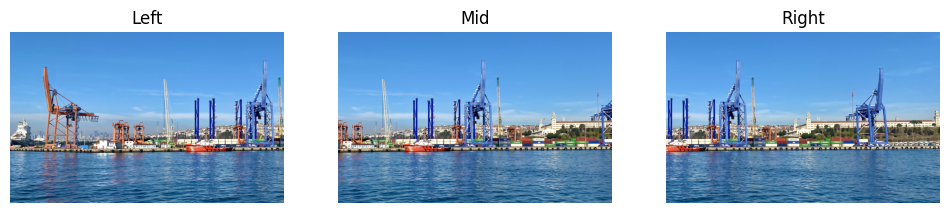

In [9]:
# Читаем и режем на 3 куска (по горизонтали), контролируем OVERLAP
bgr = cv2.imread(IMG_PATH, cv2.IMREAD_COLOR); assert bgr is not None, "Нет Waldo.png"
img = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
H, W = img.shape[:2]

# ширина кропа фиксируем долей: пусть 0.6 от ширины (можно поменять при желании)
crop_w = int(0.60 * W)
step = max(1, int(crop_w * (1.0 - OVERLAP)))  # шаг с учётом перекрытия
x0 = 0
x1 = min(W - crop_w, x0 + step)
x2 = min(W - crop_w, x1 + step)

crop_left  = img[:, x0:x0+crop_w].copy()
crop_mid   = img[:, x1:x1+crop_w].copy()
crop_right = img[:, x2:x2+crop_w].copy()

print(f"img: {img.shape}, crop_w={crop_w}, step={step}, xs={[x0,x1,x2]}")
plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.imshow(crop_left);  plt.axis("off"); plt.title("Left")
plt.subplot(1,3,2); plt.imshow(crop_mid);   plt.axis("off"); plt.title("Mid")
plt.subplot(1,3,3); plt.imshow(crop_right); plt.axis("off"); plt.title("Right")


ML (left):
 [[ 9.54760800e-01  2.97374874e-01 -1.05565152e-01]
 [-2.97374874e-01  9.54760800e-01  9.11954002e+02]] 
size: (3499, 2745)
MR (right):
 [[ 9.22538089e-01 -3.85906042e-01  7.40757640e+02]
 [ 3.85906042e-01  9.22538089e-01 -4.23481782e-01]] 
size: (3570, 2954)


Text(0.5, 1.0, 'Right rotated (контур = исходник)')

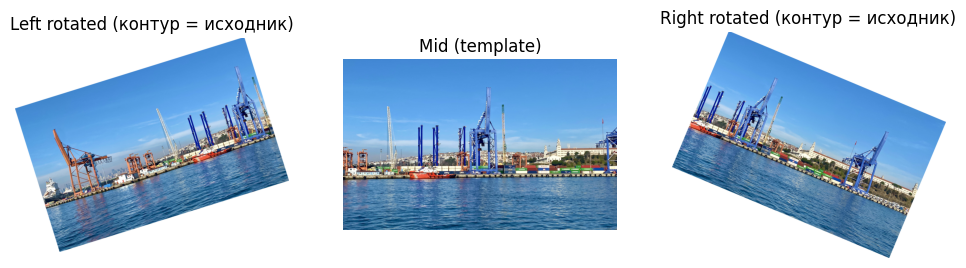

In [10]:
# Вращаем в увеличенную канву (без обрезаний углов). Рисуем контуры исходника на повернутом.
def rotate_bound_debug(crop, angle_deg):
    h, w = crop.shape[:2]
    c = (w/2, h/2)
    M = cv2.getRotationMatrix2D(c, angle_deg, 1.0)
    cos, sin = abs(M[0,0]), abs(M[0,1])
    nW = int(h*sin + w*cos); nH = int(h*cos + w*sin)
    M[0,2] += (nW/2) - c[0]; M[1,2] += (nH/2) - c[1]
    rot = cv2.warpAffine(crop, M, (nW, nH),
                         flags=cv2.INTER_LINEAR,
                         borderMode=cv2.BORDER_CONSTANT, borderValue=(255,255,255))
    # проецируем углы исходного прямоугольника на повернутый (для проверки геометрии)
    corners = np.float32([[0,0],[w,0],[w,h],[0,h]]).reshape(-1,1,2)
    corners_rot = cv2.transform(corners, M)
    dbg = rot.copy()
    poly = corners_rot.reshape(-1,2).astype(int)
    cv2.polylines(dbg, [poly], True, (0,255,0), 2, cv2.LINE_AA)  # контур исходника
    return rot, M, (nW,nH), poly

left_rot,  ML, (nWL,nHL), polyL  = rotate_bound_debug(crop_left,  +ANGLE_LEFT)   # CCW
right_rot, MR, (nWR,nHR), polyR  = rotate_bound_debug(crop_right, -ANGLE_RIGHT)  # CW

print("ML (left):\n", ML, "\nsize:", (nWL,nHL))
print("MR (right):\n", MR, "\nsize:", (nWR,nHR))

plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.imshow(left_rot);  plt.axis("off"); plt.title("Left rotated (контур = исходник)")
plt.subplot(1,3,2); plt.imshow(crop_mid);  plt.axis("off"); plt.title("Mid (template)")
plt.subplot(1,3,3); plt.imshow(right_rot); plt.axis("off"); plt.title("Right rotated (контур = исходник)")


LEFT: kps1=4000, kps2=869, good(after filters)=1


Text(0.5, 1.0, 'LEFT: good matches')

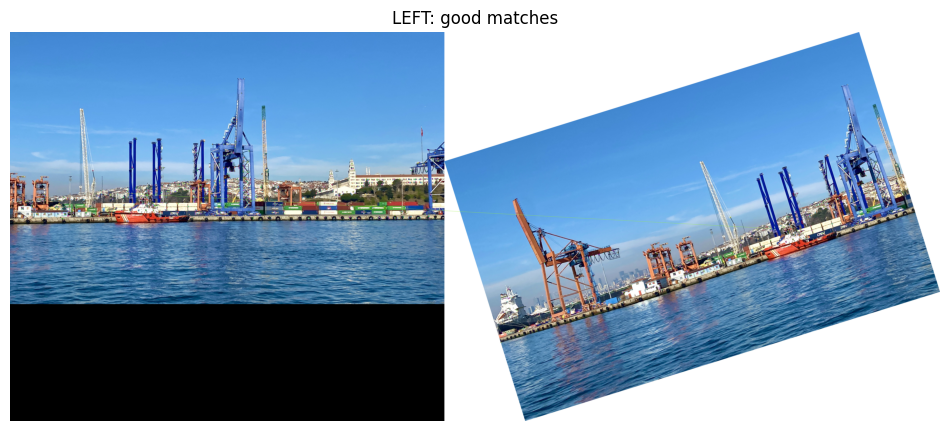

In [11]:
# Детект/матч (LEFT->MID). Маска исключает белый фон; cross-check; отчёты по количеству.
img1Gray = cv2.cvtColor(crop_mid,  cv2.COLOR_RGB2GRAY)     # dst
img2Gray = cv2.cvtColor(left_rot,  cv2.COLOR_RGB2GRAY)     # src
mask2    = (img2Gray < 250).astype(np.uint8)

orb = cv2.ORB_create(MAX_FEATURES)
kps1, d1 = orb.detectAndCompute(img1Gray, None)
kps2, d2 = orb.detectAndCompute(img2Gray, mask2)
assert d1 is not None and d2 is not None, "Пустые дескрипторы на LEFT"

bf = cv2.BFMatcher(cv2.NORM_HAMMING)
m12 = bf.knnMatch(d1, d2, k=2)
m21 = bf.knnMatch(d2, d1, k=2)

good12 = [m for m,n in m12 if m.distance < RATIO*n.distance]
good21 = [m for m,n in m21 if m.distance < RATIO*n.distance]
rev = {(m.trainIdx, m.queryIdx) for m in good21}  # (idx in d2, idx in d1)
good = [m for m in good12 if (m.trainIdx, m.queryIdx) in rev]

# фильтр по отступу от края (чтобы не брать ключи у белой рамки)
def keep_inside(kps, w, h, pad=PAD):
    S=set()
    for i,p in enumerate(kps):
        x,y = p.pt
        if pad <= x < w-pad and pad <= y < h-pad:
            S.add(i)
    return S
ok2 = keep_inside(kps2, left_rot.shape[1], left_rot.shape[0], pad=PAD)
good = [m for m in good if m.trainIdx in ok2]

print(f"LEFT: kps1={len(kps1)}, kps2={len(kps2)}, good(after filters)={len(good)}")
plt.figure(figsize=(12,6))
plt.imshow(cv2.drawMatches(crop_mid, kps1, left_rot, kps2, good, None)); plt.axis('off'); plt.title("LEFT: good matches")


In [ ]:
# Строим преобразование src(left_rot) → dst(crop_mid). Для стабильности берём affine (partial2D).
pts1 = np.float32([kps1[m.queryIdx].pt for m in good]).reshape(-1,1,2)  # dst
pts2 = np.float32([kps2[m.trainIdx].pt for m in good]).reshape(-1,1,2)  # src

A_left, inlA = cv2.estimateAffinePartial2D(
    pts2, pts1, method=cv2.RANSAC, ransacReprojThreshold=3.0,
    confidence=0.999, maxIters=10000
)
print("Affine LEFT found:", A_left is not None, "det=", (np.linalg.det(A_left[:2,:2]) if A_left is not None else None),
      "inliers=", (int(inlA.sum()) if inlA is not None else None))

# (опционально) сравнить с гомографией
method = getattr(cv2, "USAC_MAGSAC", cv2.RANSAC)
H_left, inlH = cv2.findHomography(pts2, pts1, method, 3.0, maxIters=10000, confidence=0.999)
print("Homog LEFT found:", H_left is not None, "inliers=", (int(inlH.sum()) if inlH is not None else None))

th, tw = crop_mid.shape[:2]
# используем affine как дефолт:
left_aligned = cv2.warpAffine(
    left_rot, A_left, (tw, th),
    flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT, borderValue=(255,255,255)
)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1); plt.imshow(left_aligned); plt.axis("off"); plt.title("Left aligned (affine)")
plt.subplot(1,2,2); plt.imshow(crop_mid);   plt.axis("off"); plt.title("Mid")


Affine LEFT found: False det= None inliers= 0


error: OpenCV(4.12.0) D:\a\opencv-python\opencv-python\opencv\modules\calib3d\src\usac\ransac_solvers.cpp:1047: error: (-2:Unspecified error) in function 'auto __cdecl cv::usac::mergePoints::<lambda_169b2af244bc4a759937b0b01333e54e>::operator ()(class cv::Mat &,int) const'
> Invalid dimension of point (expected: 'points.cols >= pt_dim'), where
>     'points.cols' is 1
> must be greater than or equal to
>     'pt_dim' is 2


: 

In [ ]:
img1Gray_R = cv2.cvtColor(crop_mid,   cv2.COLOR_RGB2GRAY)   # dst
img2Gray_R = cv2.cvtColor(right_rot,  cv2.COLOR_RGB2GRAY)   # src
maskR      = (img2Gray_R < 250).astype(np.uint8)

orb_R = cv2.ORB_create(MAX_FEATURES)
kps1_R, d1_R = orb_R.detectAndCompute(img1Gray_R, None)
kps2_R, d2_R = orb_R.detectAndCompute(img2Gray_R, maskR)
assert d1_R is not None and d2_R is not None, "Пустые дескрипторы на RIGHT"

bf_R = cv2.BFMatcher(cv2.NORM_HAMMING)
m12_R = bf_R.knnMatch(d1_R, d2_R, k=2)
m21_R = bf_R.knnMatch(d2_R, d1_R, k=2)

good12_R = [m for m,n in m12_R if m.distance < RATIO*n.distance]
good21_R = [m for m,n in m21_R if m.distance < RATIO*n.distance]
rev_R = {(m.trainIdx, m.queryIdx) for m in good21_R}
good_R = [m for m in good12_R if (m.trainIdx, m.queryIdx) in rev_R]

ok2_R = keep_inside(kps2_R, right_rot.shape[1], right_rot.shape[0], pad=PAD)
good_R = [m for m in good_R if m.trainIdx in ok2_R]

print(f"RIGHT: kps1={len(kps1_R)}, kps2={len(kps2_R)}, good(after filters)={len(good_R)}")
plt.figure(figsize=(12,6))
plt.imshow(cv2.drawMatches(crop_mid, kps1_R, right_rot, kps2_R, good_R, None)); plt.axis('off'); plt.title("RIGHT: good matches")


In [ ]:
pts1_R = np.float32([kps1_R[m.queryIdx].pt for m in good_R]).reshape(-1,1,2)  # dst
pts2_R = np.float32([kps2_R[m.trainIdx].pt for m in good_R]).reshape(-1,1,2)  # src

A_right, inlA_R = cv2.estimateAffinePartial2D(
    pts2_R, pts1_R, method=cv2.RANSAC, ransacReprojThreshold=3.0,
    confidence=0.999, maxIters=10000
)
print("Affine RIGHT found:", A_right is not None, "det=", (np.linalg.det(A_right[:2,:2]) if A_right is not None else None),
      "inliers=", (int(inlA_R.sum()) if inlA_R is not None else None))

method = getattr(cv2, "USAC_MAGSAC", cv2.RANSAC)
H_right, inlH_R = cv2.findHomography(pts2_R, pts1_R, method, 3.0, maxIters=10000, confidence=0.999)
print("Homog RIGHT found:", H_right is not None, "inliers=", (int(inlH_R.sum()) if inlH_R is not None else None))

th, tw = crop_mid.shape[:2]
right_aligned = cv2.warpAffine(
    right_rot, A_right, (tw, th),
    flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT, borderValue=(255,255,255)
)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1); plt.imshow(right_aligned); plt.axis("off"); plt.title("Right aligned (affine)")
plt.subplot(1,2,2); plt.imshow(crop_mid);     plt.axis("off"); plt.title("Mid")
